# Capstone Project - The Battle of the Neighborhoods (2/2)
Applied Data Science Capstone by IBM/Coursera

## Introduction


This project is about electing the best place for a restaurant in Paris.Due to the density of population in Paris, there is a lot of restaurants cafe and bistro everywhere. The huge metropolitan has many neighborhoods and the success of a restaurant depends in part in the location. Paris has 20 neighborhood which I investigated in this project and I used different criteria to reduce the number of possible location to two and then to an optimal one. This project is of interest to the restaurant owners or future owners. It gives a good idea of the cost of neighborhood and their most common venues.This is important because if you choose for example to open a fast food place it would be better located near a university or offices however if it is a fine cuisine restaurant so better go with residential neighborhood or a fashion/shopping street.

## Data

Foursquare was used to locate metro stations, cafes, bistros and restaurants in the first part. It is important to choose a location near a metro station and not too closeto other restaurants and bistro.
Foursquare was afterwards used to investigate the surrounding of the final two places selected by considering all the categories ( shops, schools, office, galleries…) in order to understand what type of people( workers, shoppers, kids, teenagers..) are mostly there.

As the data of Foursquare have Nan as value for the name of the neighborhoods, but lists the postal Codes, I looked for a website that have the postal Code and the name of each neighborhood to complement my data:

https://www.worldpostalcodes.org/en/france/arrondissement/map-of-postal-codes-in-paris

I couldn’t find the exact cost of rent for commercial buildings for all neighborhoods so I compared instead the price per meter square based on this website, since it is also related to the type of neighborhood ( residential, density of shopping places...

https://edito.seloger.com/actualites/barometre-lpi-seloger/paris-quel-prix-immobilier-dans-votre-arrondissement-article-31984.html,

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


In [4]:
import folium # plotting library

print('Folium installed')

Folium installed


Foursquare credentials

In [137]:
CLIENT_ID = ' ' # your Foursquare ID
CLIENT_SECRET = ' ' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 1000

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [18]:
address = 'Paris, Fr'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

48.8566969 2.3514616


Prepare for requests for metro station, bistro, cafe and restaurants

In [19]:
search_query = 'restaurant'
radius = 50000
print(search_query + ' .... OK!')

restaurant .... OK!


In [20]:
search_query2 = 'bistro'
search_query3='metro station'
search_query4='cafe'

In [22]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query2, radius, LIMIT)
url3= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query3, radius, LIMIT)
url4= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query4, radius, LIMIT)

In [23]:
results = requests.get(url).json()
results2 = requests.get(url2).json()
results3= requests.get(url3).json()
results4= requests.get(url4).json()

In [24]:
##Restaurants##

# assign relevant part of JSON to venues
venues = results['response']['venues']
# tranform venues into a dataframe
dataframe = json_normalize(venues)

##Metro and cafe##

# assign relevant part of JSON to venues
Metro_station = results3['response']['venues']
cafe=results4['response']['venues']
# tranform venues into a dataframe
dataframe_metro = json_normalize(Metro_station)
data_cafe=json_normalize(cafe)

##Bistros##

# assign relevant part of JSON to venues
bistro = results2['response']['venues']
# tranform venues into a dataframe
dataframe_bistro = json_normalize(bistro)


In [27]:
# keep only columns that include venue name, and anything tha_cafet is associated with location
filtered_columns_cafe = ['name', 'categories'] + [col for col in data_cafe.columns if col.startswith('location.')] + ['id']
dataframe_filtered_cafe = data_cafe.loc[:, filtered_columns_cafe]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered_cafe['categories'] = dataframe_filtered_cafe.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered_cafe.columns = [column.split('.')[-1] for column in dataframe_filtered_cafe.columns]

dataframe_filtered_cafe.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Café de Flore,Café,172 boulevard Saint-Germain,FR,Paris,France,NaN,1410,"[172 boulevard Saint-Germain, 75006 Paris, Fra...","[{'label': 'display', 'lat': 48.85399681424528...",48.853997,2.332646,NaN,75006,Île-de-France,4adcda04f964a520323221e3
1,Café Rive Droite,Karaoke Bar,2 rue Berger,FR,Paris,France,NaN,500,"[2 rue Berger, 75001 Paris, France]","[{'label': 'display', 'lat': 48.86084691113991...",48.860847,2.348837,NaN,75001,Île-de-France,4adcda08f964a520803321e3
2,Shakespeare & Company Café,Coffee Shop,37 rue de la Bûcherie,FR,Paris,France,NaN,557,"[37 rue de la Bûcherie, 75005 Paris, France]","[{'label': 'display', 'lat': 48.85252686799679...",48.852527,2.347244,NaN,75005,Île-de-France,562a40c3498e425bd63baa85
3,Café Voulez-Vous,Gay Bar,18 rue du Temple,FR,Paris,France,NaN,253,"[18 rue du Temple, 75004 Paris, France]","[{'label': 'display', 'lat': 48.85853064543159...",48.858531,2.353510,NaN,75004,Île-de-France,4bb5dd68941ad13a6c941ee3
4,Café Oz,Pub,18 rue Saint-Denis,FR,Paris,France,NaN,392,"[18 rue Saint-Denis, 75001 Paris, France]","[{'label': 'display', 'lat': 48.85938756682635...",48.859388,2.348008,NaN,75001,Île-de-France,4adcda06f964a520b73221e3


In [28]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns_metro = ['name', 'categories'] + [col for col in dataframe_metro.columns if col.startswith('location.')] + ['id']
dataframe_filtered_metro = dataframe_metro.loc[:, filtered_columns_metro]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered_metro['categories'] = dataframe_filtered_metro.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered_metro.columns = [column.split('.')[-1] for column in dataframe_filtered_metro.columns]


In [30]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns_bistro = ['name', 'categories'] + [col for col in dataframe_bistro.columns if col.startswith('location.')] + ['id']
dataframe_filtered_bistro = dataframe_bistro.loc[:, filtered_columns_bistro]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered_bistro['categories'] = dataframe_filtered_bistro.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered_bistro.columns = [column.split('.')[-1] for column in dataframe_filtered_bistro.columns]

#dataframe_filtered_bistro.head()

In [31]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#dataframe_filtered

In [171]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
 #   popup='Conrad Hotel',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the  restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
# add the bistro as green circle markers
for lat, lng, label in zip(dataframe_filtered_bistro.lat, dataframe_filtered_bistro.lng, dataframe_filtered_bistro.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
    # add the metro stations as orange circle markers
for lat, lng, label in zip(dataframe_filtered_metro.lat, dataframe_filtered_metro.lng, dataframe_filtered_metro.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=4,
        color='orange',
        popup=label,
        fill = True,
        fill_color='orange',
        fill_opacity=0.6
    ).add_to(venues_map)
for lat, lng, label in zip(dataframe_filtered_cafe.lat, dataframe_filtered_cafe.lng, dataframe_filtered_cafe.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=4,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)    
# display map
venues_map

## Maps of the metro station in orange and the venues( restauants, bistros, and cafe) in blue

In [139]:
dataframe_merged=pd.concat([dataframe_filtered,dataframe_filtered_bistro,dataframe_filtered_cafe] )
dataframe_merged=dataframe_merged.reset_index()
dataframe_merged.head()


,index,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,0,Restaurant Aux Tours de Notre-Dame,French Restaurant,23 rue d'Arcole,FR,Paris,France,NaN,373,"[23 rue d'Arcole, 75004 Paris, France]","[{'label': 'display', 'lat': 48.85362193008465...",48.853622,2.349421,NaN,75004,Île-de-France,50445ef7e4b0ba0a539ad83f
1,1,Le Restaurant du Musée d'Orsay,French Restaurant,1 rue de la Légion d'Honneur,FR,Paris,France,NaN,1950,"[1 rue de la Légion d'Honneur, 75007 Paris, Fr...","[{'label': 'display', 'lat': 48.86029986248957...",48.860300,2.325392,NaN,75007,Île-de-France,4cbb05054352a1cd0d4396f5
2,2,Le Restaurant des Poètes,French Restaurant,12 passage Molière,FR,Paris,France,NaN,626,"[12 passage Molière, 75003 Paris, France]","[{'label': 'display', 'lat': 48.86232131013030...",48.862321,2.351590,NaN,75003,Île-de-France,4e2b2d0ad22d3f83c88c7029
3,3,Restaurant Costes Saint-Honoré,French Restaurant,Hôtel Costes,FR,Paris,France,239 rue Saint-Honoré,2053,"[Hôtel Costes (239 rue Saint-Honoré), Paris, F...","[{'label': 'display', 'lat': 48.86669789450374...",48.866698,2.327894,NaN,NaN,Île-de-France,52cf091111d2d9bb920d6122
4,4,Restaurant Au 35,French Restaurant,91 rue La Boétie,FR,Paris,France,NaN,1343,"[91 rue La Boétie, 75008 Paris, France]","[{'label': 'display', 'lat': 48.85568519411101...",48.855685,2.333184,NaN,75008,Île-de-France,4d4960ae9544a09370bb27e7


## Analysis

Insert missing data of the neighborhood name

In [142]:
pc=['75001','75002','75003','75004','75005','75006','75007','75008','75009','75010','75011','75012','75013','75014','75015','75016','75017','75018','75019','75020']
neighborhood=['1 ère arrondissement','2 ème arrondissement','3 ème arrondissement','4 ème arrondissement','5 ème arrondissement','6 ème arrondissement','7 ème arrondissement','8 ème arrondissement','9 ème arrondissement','10 ème arrondissement','11 ème arrondissement','12 ème arrondissement','13 ème arrondissement','14 ème arrondissement','15 ème arrondissement','16 ème arrondissement','17 ème arrondissement','18 ème arrondissement','19 ème arrondissement','20 ème arrondissement']
pc_df=pd.DataFrame(pc,neighborhood)
pc_df.reset_index(inplace=True)
pc_df.columns=['neighborhood','postalCode']

In [143]:
dataframe_merged=pd.merge(dataframe_merged,pc_df,on='postalCode')  
dataframe_merged.sort_values(by='neighborhood')

,index,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood_x,postalCode,state,id,neighborhood_y,neighborhood
67,49,Café Kitsuné,Coffee Shop,208 rue de Rivoli,FR,Paris,France,NaN,1773,"[208 rue de Rivoli, 75001 Paris, France]","[{'label': 'display', 'lat': 48.864451, 'lng':...",48.864451,2.330310,NaN,75001,Île-de-France,5d60faf7f3994200085693d4,1 ère arrondissement,1 ère arrondissement
62,28,Indiana Café – Les Halles,Latin American Restaurant,35 rue du Pont Neuf,FR,Paris,France,NaN,728,"[35 rue du Pont Neuf, 75001 Paris, France]","[{'label': 'display', 'lat': 48.86149645567914...",48.861496,2.344701,NaN,75001,Île-de-France,4f833d8ce4b03e850ae9cbbc,1 ère arrondissement,1 ère arrondissement
61,26,Isis Café,Hookah Bar,31 rue des Lombards,FR,Paris,France,NaN,383,"[31 rue des Lombards, 75001 Paris, France]","[{'label': 'display', 'lat': 48.85952873863096...",48.859529,2.348474,NaN,75001,Île-de-France,4bb783833db7b7132f13209a,1 ère arrondissement,1 ère arrondissement
60,21,Café Saint-Honoré,French Restaurant,194 rue Saint-Honoré,FR,Paris,France,NaN,1181,"[194 rue Saint-Honoré, 75001 Paris, France]","[{'label': 'display', 'lat': 48.86261500770269...",48.862615,2.338071,NaN,75001,Île-de-France,4b9b9583f964a520621136e3,1 ère arrondissement,1 ère arrondissement
59,19,Le Café Blanc,Bar,10 rue Croix des Petits Champs,FR,Paris,France,NaN,1098,"[10 rue Croix des Petits Champs, 75001 Paris, ...","[{'label': 'display', 'lat': 48.862719, 'lng':...",48.862719,2.339578,NaN,75001,Île-de-France,4b7b0998f964a520bf4d2fe3,1 ère arrondissement,1 ère arrondissement
58,17,Café Kitsuné,Coffee Shop,2 place André Malraux,FR,Paris,France,NaN,1405,"[2 place André Malraux, 75001 Paris, France]","[{'label': 'display', 'lat': 48.86398250462098...",48.863983,2.335794,NaN,75001,Île-de-France,5d5d299759e2b50008c0127d,1 ère arrondissement,1 ère arrondissement
57,16,Café Palais Royal,Brasserie,202 rue Saint-Honoré,FR,Paris,France,Rue de Valois,1216,"[202 rue Saint-Honoré (Rue de Valois), 75001 P...","[{'label': 'display', 'lat': 48.86275774194002...",48.862758,2.337638,NaN,75001,Île-de-France,4b51bcfbf964a520f65327e3,1 ère arrondissement,1 ère arrondissement
56,15,Café du Pont-Neuf,Café,14 quai du Louvre,FR,Paris,France,NaN,775,"[14 quai du Louvre, 75001 Paris, France]","[{'label': 'display', 'lat': 48.85873534831587...",48.858735,2.341334,NaN,75001,Île-de-France,4b4a0bdbf964a520e87826e3,1 ère arrondissement,1 ère arrondissement
55,9,Café du Châtelet,Café,8 rue Saint-Denis,FR,Paris,France,NaN,363,"[8 rue Saint-Denis, 75001 Paris, France]","[{'label': 'display', 'lat': 48.8585470820035,...",48.858547,2.347379,NaN,75001,Île-de-France,4bbcc5db8ec3d13ac3351b28,1 ère arrondissement,1 ère arrondissement
54,8,Café Ruc,Coffee Shop,159 rue Saint-Honoré,FR,Paris,France,NaN,1388,"[159 rue Saint-Honoré, 75001 Paris, France]","[{'label': 'display', 'lat': 48.86314822566314...",48.863148,2.335228,NaN,75001,Île-de-France,4adcda06f964a520cc3221e3,1 ère arrondissement,1 ère arrondissement


In [144]:
# one hot encoding
paris_onehot = pd.get_dummies(dataframe_merged[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['neighborhood'] = dataframe_merged['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,neighborhood,American Restaurant,Bagel Shop,Bar,Bistro,Brasserie,Burger Joint,Cafeteria,Café,Cajun / Creole Restaurant,...,Persian Restaurant,Pizza Place,Pub,Restaurant,Sandwich Place,Szechuan Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vietnamese Restaurant
0,4 ème arrondissement,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4 ème arrondissement,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4 ème arrondissement,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4 ème arrondissement,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4 ème arrondissement,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
paris_grouped = paris_onehot.groupby('neighborhood').mean().reset_index()
paris_grouped.head()

,neighborhood,American Restaurant,Bagel Shop,Bar,Bistro,Brasserie,Burger Joint,Cafeteria,Café,Cajun / Creole Restaurant,...,Persian Restaurant,Pizza Place,Pub,Restaurant,Sandwich Place,Szechuan Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vietnamese Restaurant
0,1 ère arrondissement,0.0,0.0,0.076923,0.038462,0.038462,0.038462,0.0,0.192308,0.0,...,0.0,0.0,0.038462,0.000,0.038462,0.000,0.0,0.00,0.038462,0.0
1,10 ème arrondissement,0.0,0.0,0.125000,0.250000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.125,0.000000,0.125,0.0,0.25,0.000000,0.0
2,11 ème arrondissement,0.0,0.0,0.000000,0.400000,0.000000,0.000000,0.0,0.200000,0.2,...,0.0,0.0,0.000000,0.200,0.000000,0.000,0.0,0.00,0.000000,0.0
3,12 ème arrondissement,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.500000,0.0,...,0.0,0.0,0.000000,0.000,0.000000,0.000,0.0,0.00,0.000000,0.0
4,14 ème arrondissement,0.0,0.0,0.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000,0.000000,0.000,0.0,0.00,0.000000,0.0


In [172]:
num_top_venues = 8

for hood in paris_grouped['neighborhood']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

----1 ère arrondissement----
                       venue  freq
0          French Restaurant  0.19
1                       Café  0.19
2                Coffee Shop  0.12
3                        Bar  0.08
4               Cocktail Bar  0.04
5                 Hookah Bar  0.04
6  Latin American Restaurant  0.04
7                 Food Court  0.04
----10 ème arrondissement----
                       venue  freq
0                     Bistro  0.25
1         Turkish Restaurant  0.25
2                        Bar  0.12
3          French Restaurant  0.12
4        Szechuan Restaurant  0.12
5                 Restaurant  0.12
6        American Restaurant  0.00
7  Middle Eastern Restaurant  0.00
----11 ème arrondissement----
                       venue  freq
0                     Bistro   0.4
1                 Restaurant   0.2
2                       Café   0.2
3  Cajun / Creole Restaurant   0.2
4                Pizza Place   0.0
5                  Hotel Bar   0.0
6         Italian Restaurant   0.0
7

In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [50]:
num_top_venues =8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood'] = paris_grouped['neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,1 ère arrondissement,French Restaurant,Café,Coffee Shop,Bar,Latin American Restaurant,Hookah Bar,Food Court,Bistro
1,10 ème arrondissement,Turkish Restaurant,Bistro,French Restaurant,Szechuan Restaurant,Bar,Restaurant,Chinese Restaurant,Creperie
2,11 ème arrondissement,Bistro,Cajun / Creole Restaurant,Restaurant,Café,City Hall,Fast Food Restaurant,Creperie,Corporate Cafeteria
3,12 ème arrondissement,Corporate Cafeteria,Café,Vietnamese Restaurant,Chinese Restaurant,Fast Food Restaurant,Creperie,College Cafeteria,Coffee Shop
4,14 ème arrondissement,Bistro,College Cafeteria,Vietnamese Restaurant,Chinese Restaurant,Fast Food Restaurant,Creperie,Corporate Cafeteria,Coffee Shop


Identify the clusters

In [51]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 4
paris_grouped_clustering =paris_grouped.drop('neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:16] 

array([3, 3, 0, 2, 0, 0, 0, 1, 0, 0, 3, 3, 3, 3, 3, 3])

In [52]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = dataframe2

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('neighborhood'), on='neighborhood')


In [53]:
paris_merged = paris_merged[pd.notnull(paris_merged['Cluster Labels'])]
paris_merged['Cluster Labels']=paris_merged['Cluster Labels'].astype(int)
paris_merged['Cluster Labels'].head()


0    3
1    3
2    3
3    3
4    3
Name: Cluster Labels, dtype: int32

In [18]:
dataframe_filtered_metro=pd.merge(dataframe_filtered_metro,a,on='postalCode')  
dataframe_filtered_metro.sort_values(by='neighborhood_y')


In [169]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster in zip(paris_merged['lat'], paris_merged['lng'], paris_merged['neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color="red",
        #rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
# add the metro stations as orange circle markers
for lat, lng, label in zip(dataframe_filtered_metro['lat'], dataframe_filtered_metro['lng'], dataframe_filtered_metro.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=3,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6    ).add_to(map_clusters)
map_clusters

# Map of the fours clusters ( the two clusters(bistro and restaurant ) have the majority)

In [157]:
#paris_merged[['Cluster Labels','neighborhood','1st Most Common Venue','2nd Most Common Venue']].sort_values(by='Cluster Labels')

Comparison of the cost of neighborhoods

from https://edito.seloger.com/actualites/barometre-lpi-seloger/paris-quel-prix-immobilier-dans-votre-arrondissement-article-31984.html, the price of m2 was taken to compare the affordabiltiy of  a restaurant:
the most cosltly neighborhood are:
1. 6e (13 944 €/ m²)
2. 7e (13 569 €/ m²)
3. 4e (13 262 €/ m²)

and the cheapest are:

1. 20e (7 853 €/ m²)
2. 19e (7 909 €/ m²)
3. 13e (8 156 €/ m²)

In [59]:
y=[9816, 11262, 11560, 13262, 11609, 13944, 13569, 12436, 10497, 9441, 9571, 8836, 8156, 9531, 9583, 11753 , 10930, 8874, 7909, 7853],
x=list(range(1,21))
x=np.array(x)
y=np.array(y)
df=pd.DataFrame(x)
y=np.transpose(y)
df2=pd.DataFrame(y)
df3=pd.concat([df,df2],axis=1)
df3.columns=['neighborhood','price']

<Figure size 1440x720 with 0 Axes>

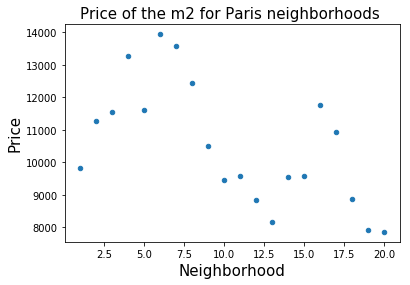

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=[20,10])


df3.plot(kind='scatter', x='neighborhood', y='price');
plt.xlabel('Neighborhood',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.title('Price of the m2 for Paris neighborhoods ',fontsize=15)
plt.show()

according to those results, our focus will be in the following neighborhoods:
    10,11,12,13,14,15,18,19,20  
 The remaining neighborhood will be dropped

In [158]:
data=dataframe_merged
data2=data[['neighborhood','name','categories','address','distance','formattedAddress','postalCode','id','lat','lng']]
data2 = data2.sort_values(by ='neighborhood' ,ascending=True)
data2.reset_index(inplace=True)
data23=data2.iloc[26:46,:]
data24=data2.iloc[54:56,:]
data_needed=pd.concat([data23,data24])
data_needed.reset_index(inplace=True)
data_needed.head()

,level_0,index,neighborhood,name,categories,address,distance,formattedAddress,postalCode,id,lat,lng
0,26,90,10 ème arrondissement,Restaurant Deluxe,Turkish Restaurant,50 rue du Faubourg Saint-Denis,1722,"[50 rue du Faubourg Saint-Denis, 75010 Paris, ...",75010,4cd0b05f3e63721e99bb9fcc,48.872084,2.353884
1,27,91,10 ème arrondissement,Restaurant de Bourgogne Chez Maurice,French Restaurant,26 rue des Vinaigriers,2023,"[26 rue des Vinaigriers, 75010 Paris, France]",75010,51ed8718498e4ec0b47d20ad,48.873235,2.362928
2,28,92,10 ème arrondissement,Restaurant Le Robinet d'Or,Bistro,17 rue Robert Blache,2566,"[17 rue Robert Blache (Hôtel Le Robinet d'Or),...",75010,4fe448d3e4b04acf4e29c12f,48.878025,2.364761
3,29,93,10 ème arrondissement,A Hot Pot Restaurant 一家,Szechuan Restaurant,27 rue d'Enghien,1712,"[27 rue d'Enghien, 75010 Paris, France]",75010,51a74554498ec9c71a81d965,48.872076,2.350661
4,30,94,10 ème arrondissement,Bistro Saint-Quentin du Marché Saint-Quentin,Bar,85 bis boulevard de Magenta,2260,[85 bis boulevard de Magenta (Marché Saint-Que...,75010,4f534a01e4b092980ec7c66a,48.876845,2.355344


In [62]:
df_cluster=data_needed[['lng','lat']]
df_cluster.columns=['lng','lat']
df_cluster.head()

,lng,lat
0,2.353884,48.872084
1,2.362928,48.873235
2,2.364761,48.878025
3,2.350661,48.872076
4,2.355344,48.876845


the choice is then between the following neighborhoods:10,11,12,14,15,20  
the following maps conatins the venues of only these neighborhoods

In [173]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, poi in zip(data_needed['lat'], data_needed['lng'], data_needed['neighborhood']):
    label = folium.Popup(str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color="red",
        fill=True,
        fill_color="red",
        #rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
# add the metro stations as orange circle markers
##for lat, lng, label in zip(dataframe_filtered_metro['lat'], dataframe_filtered_metro['lng'], dataframe_filtered_metro.categories):
##    folium.features.CircleMarker(
##        [lat, lng],
##        radius=3,
##        color='blue',
##        popup=label,
##        fill = True,
##        fill_color='blue',
##        fill_opacity=0.6
##    ).add_to(map_clusters)
  
map_clusters

## Map of the venues in the selected neighborhoods

For a better visualization a heat map is chosen

In [64]:
from folium import plugins
from folium.plugins import HeatMap

In [174]:
map_hooray = folium.Map(location=[48.8566969 ,2.3514616],
                    zoom_start = 12) 

# Ensure you're handing it floats
data_needed['lat'] = data_needed['lat'].astype(float)
data_needed['lng']= data_needed['lng'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
#heat_df = df_acc[df_acc['Speed_limit']=='40'] # Reducing data size so it runs faster
#heat_df = df_acc[df_acc['Year']=='2007'] # Reducing data size so it runs faster
heat_df = data_needed[['lat', 'lng']]
heat_df = heat_df.dropna(axis=0, subset=['lat','lng'])

# List comprehension to make out list of lists
heat_data = [[row['lat'],row['lng']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(map_hooray)

map_hooray

## Heat Map of the venues in the selected neighborhoods

this limits the nighborhood to 11,12,14,15 and 20. Since the remaining are wether too crowded or too empty  
the restaurant should be located near a metro station and far enough from other restaurants  
let's use the k-mean clustering to have an approximate coordinates of the possible locations

In [66]:
colors_map = np.array(['b', 'r'])
def assign_members(x1, x2, centers):
    compare_to_first_center = np.sqrt(np.square(np.array(x1) - centers[0][0]) + np.square(np.array(x2) - centers[0][1]))
    compare_to_second_center = np.sqrt(np.square(np.array(x1) - centers[1][0]) + np.square(np.array(x2) - centers[1][1]))
    class_of_points = compare_to_first_center > compare_to_second_center
    colors = colors_map[class_of_points + 1 - 1]
    return colors, class_of_points

print('assign_members function defined!')

assign_members function defined!


In [67]:
# update means
def update_centers(x1, x2, class_of_points):
    center1 = [np.mean(np.array(x1)[~class_of_points]), np.mean(np.array(x2)[~class_of_points])]
    center2 = [np.mean(np.array(x1)[class_of_points]), np.mean(np.array(x2)[class_of_points])]
    return [center1, center2]

print('assign_members function defined!')

assign_members function defined!


In [68]:
def plot_points(centroids=None, colors='g', figure_title=None):
    # plot the figure
    fig = plt.figure(figsize=(15, 10))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    
    centroid_colors = ['bx', 'rx']
    if centroids:
        for (i, centroid) in enumerate(centroids):
            ax.plot(centroid[0], centroid[1], centroid_colors[i], markeredgewidth=5, markersize=20)
    plt.scatter(x1, x2, s=500, c=colors)
    
    # define the ticks
    xticks = np.linspace(-6, 8, 15, endpoint=True)
    yticks = np.linspace(-6, 6, 13, endpoint=True)

    # fix the horizontal axis
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    # add tick labels
    xlabels = xticks
    ax.set_xticklabels(xlabels)
    ylabels = yticks
    ax.set_yticklabels(ylabels)

    # style the ticks
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params('both', length=2, width=1, which='major', labelsize=15)
    
    # add labels to axes
    ax.set_xlabel('x1', fontsize=20)
    ax.set_ylabel('x2', fontsize=20)
    
    # add title to figure
    ax.set_title(figure_title, fontsize=24)

    plt.show()

print('plot_points function defined!')

plot_points function defined!


In [69]:
k_means = KMeans(init="k-means++", n_clusters=5, n_init=12)
k_means.fit(df_cluster)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[ 2.33732986, 48.81911353],
       [ 2.37085528, 48.85154363],
       [ 2.35574604, 48.87254047],
       [ 2.32173833, 48.83995924],
       [ 2.39994348, 48.8572456 ]])

In [70]:
df_cluster=np.array(df_cluster)

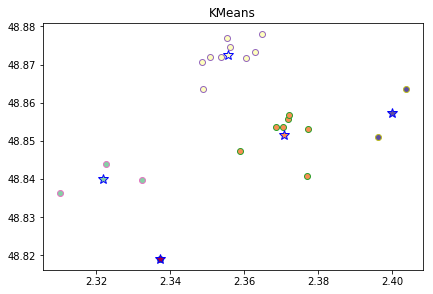

In [71]:
# initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(15, 10))

# colors uses a color map, which will produce an array of colors based on
# the number of labels. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# create a plot
ax = fig.add_subplot(2, 2, 1)

# loop through the data and plot the datapoints and centroids.
# k will range from 0-3, which will match the number of clusters in the dataset.
for k, col in zip(range(len([[3,45], [3,45], [3,45],[3,45],[3,45]])), colors):

    # create a list of all datapoints, where the datapoitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # plot the datapoints with color col.
    ax.plot(df_cluster[my_members,0],df_cluster[my_members,1], 'v', markerfacecolor=col,marker='.',markersize=12)
    
    # plot the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], '*', markerfacecolor=col,  markeredgecolor='b', markersize=10)

# title of the plot
ax.set_title('KMeans')

# remove x-axis ticks
#ax.set_xticks(())

# remove y-axis ticks
#ax.set_yticks(())

# show the plot
plt.show()

We will explore the  surrounding of the three cluster of interest with foursquare,in order to judge which looks like a better place  
2.39552425, 48.85947888 :   
2.32563621, 48.83474781: cemetery, memorial site and tech startup  
2.37124654, 48.85119842  

## Results and discussion

In [72]:
search_query_new=''
latitude_new=48.85119842
longitude_new= 2.37124654 #bastille
latitude_new2=48.85
longitude_new2=2.4  #place de la nation
radius_new=10

url_new = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_new, longitude_new, VERSION, search_query_new, radius_new, LIMIT)
results_new = requests.get(url_new).json()
venues_new = results_new['response']['venues']

url_new2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_new2, longitude_new2, VERSION, search_query_new, radius_new, LIMIT)
results_new2 = requests.get(url_new2).json()
venues_new2 = results_new2['response']['venues']

# tranform venues into a dataframe
dataframe_new = json_normalize(venues_new)
dataframe_new2 = json_normalize(venues_new2)

# keep only columns that include venue name, and anything that is associated with location
filtered_new_columns = ['name', 'categories'] + [col for col in dataframe_new.columns if col.startswith('location.')] + ['id']
dataframe_filtered_new = dataframe_new.loc[:, filtered_new_columns]

filtered_new_columns2 = ['name', 'categories'] + [col for col in dataframe_new2.columns if col.startswith('location.')] + ['id']
dataframe_filtered_new2 = dataframe_new2.loc[:, filtered_new_columns2]


# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered_new['categories'] = dataframe_filtered_new.apply(get_category_type, axis=1)
dataframe_filtered_new2['categories'] = dataframe_filtered_new2.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered_new.columns = [column.split('.')[-1] for column in dataframe_filtered_new.columns]
dataframe_filtered_new.columns2 = [column.split('.')[-1] for column in dataframe_filtered_new2.columns]

dataframe_filtered_new2.rename(columns={'location.lat':'lat'}, inplace=True)
dataframe_filtered_new2.rename(columns={'location.lng':'lng'}, inplace=True)
dataframe_filtered_new2.head()

C:\Users\Fatma\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


,name,categories,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,lat,lng,location.neighborhood,location.postalCode,location.state,id
0,Monoprix,Supermarket,6 rue de la Plaine,FR,Paris,France,20 boulevard de Charonne,79,[6 rue de la Plaine (20 boulevard de Charonne)...,"[{'label': 'display', 'lat': 48.84949, 'lng': ...",48.849490,2.399240,NaN,75020,Île-de-France,4b71abfff964a5201a552de3
1,Castorama,Furniture / Home Store,9-11 cours de Vincennes,FR,Paris,France,NaN,155,"[9-11 cours de Vincennes, 75020 Paris, France]","[{'label': 'display', 'lat': 48.84861, 'lng': ...",48.848610,2.399870,NaN,75020,Île-de-France,4c134ff87f7f2d7fd4e5de68
2,Les Pères Populaires,Bar,46 rue de Buzenval,FR,Paris,France,NaN,178,"[46 rue de Buzenval, 75020 Paris, France]","[{'label': 'display', 'lat': 48.850993, 'lng':...",48.850993,2.401913,NaN,75020,Île-de-France,4b477ff1f964a520163426e3
3,Khun Akorn,Thai Restaurant,8 avenue de Taillebourg,FR,Paris,France,NaN,149,"[8 avenue de Taillebourg, 75011 Paris, France]","[{'label': 'display', 'lat': 48.84972930004837...",48.849729,2.398000,NaN,75011,Île-de-France,4b81a076f964a520a8b330e3
4,Ecole Elémentaire,College Classroom,9 rue de la Plaine,FR,Paris,France,NaN,116,"[9 rue de la Plaine, 75020 Paris, France]","[{'label': 'display', 'lat': 48.85004617905483...",48.850046,2.401592,NaN,75020,Île-de-France,4b9caf87f964a520547636e3


In [175]:
venues_map_new = folium.Map(location=[latitude_new, longitude_new], zoom_start=15) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.features.CircleMarker(
    [latitude_new, longitude_new],
    radius=10,
    color='red',
 #   popup='Conrad Hotel',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map_new)


# add the  restaurants as blue circle markers
for latitude, lng, label in zip(dataframe_filtered_new.lat, dataframe_filtered_new.lng, dataframe_filtered_new.categories):
    folium.features.CircleMarker(
        [latitude, lng],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(venues_map_new)
# display map
venues_map_new

## Map of the venues close to la Bastille

In [176]:
venues_map_new2 = folium.Map(location=[latitude_new2, longitude_new2], zoom_start=15) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.features.CircleMarker(
    [latitude_new2, longitude_new2],
    radius=8,
    color='orange',
    fill = True,
    fill_color = 'orange',
    fill_opacity = 0.6
).add_to(venues_map_new2)

# add the  restaurants as blue circle markers

for latitude, lng in zip(dataframe_filtered_new2.lat, dataframe_filtered_new2.lng):
    folium.features.CircleMarker(
        [latitude, lng],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(venues_map_new2)
# display map


venues_map_new2

## Map of the venues close to place de la Nation

In [75]:
paris_onehot_new = pd.get_dummies(dataframe_filtered_new[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot_new['postalCode'] = dataframe_filtered_new['postalCode'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot_new.columns[-1]] + list(paris_onehot_new.columns[:-1])
paris_onehot_new = paris_onehot_new[fixed_columns]

paris_grouped_new= paris_onehot_new.groupby('postalCode').mean().reset_index()
paris_grouped_new

,postalCode,Animal Shelter,Art Gallery,Asian Restaurant,Bar,Brasserie,Burger Joint,Conference Room,Diner,General Entertainment,...,Office,Opera House,Pizza Place,Smoke Shop,Southwestern French Restaurant,Szechuan Restaurant,Tech Startup,Thai Restaurant,Vegetarian / Vegan Restaurant,Wine Shop
0,75004,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
1,75006,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,75011,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.0
3,75012,0.0,0.043478,0.0,0.043478,0.043478,0.0,0.0,0.043478,0.043478,...,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.0
4,75017,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,94340,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [76]:
num_top_venues =8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['postalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_new = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_new['postalCode'] = paris_grouped_new['postalCode']

for ind in np.arange(paris_grouped_new.shape[0]):
    neighborhoods_venues_sorted_new.iloc[ind, 1:] = return_most_common_venues(paris_grouped_new.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_new

,postalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,75004,Wine Shop,Hotel,Art Gallery,Asian Restaurant,Bar,Brasserie,Burger Joint,Conference Room
1,75006,Jewelry Store,Wine Shop,Hotel,Art Gallery,Asian Restaurant,Bar,Brasserie,Burger Joint
2,75011,Tech Startup,Wine Shop,Hotel,Art Gallery,Asian Restaurant,Bar,Brasserie,Burger Joint
3,75012,Hotel,Italian Restaurant,Mediterranean Restaurant,General Entertainment,Brasserie,Health & Beauty Service,Hobby Shop,Bar
4,75017,Animal Shelter,Hotel,Art Gallery,Asian Restaurant,Bar,Brasserie,Burger Joint,Conference Room
5,94340,Burger Joint,Wine Shop,Hotel,Art Gallery,Asian Restaurant,Bar,Brasserie,Conference Room


near Bastille it is mostly wine shops and hotels

In [77]:
paris_onehot_new2 = pd.get_dummies(dataframe_filtered_new2[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot_new2['location.postalCode'] = dataframe_filtered_new2['location.postalCode'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot_new2.columns[-1]] + list(paris_onehot_new2.columns[:-1])
paris_onehot_new2 = paris_onehot_new2[fixed_columns]

paris_grouped_new2= paris_onehot_new2.groupby('location.postalCode').mean().reset_index()
paris_grouped_new2

,location.postalCode,Asian Restaurant,Bakery,Bank,Bar,Bed & Breakfast,Bike Rental / Bike Share,Bistro,Bookstore,Building,...,Record Shop,Residential Building (Apartment / Condo),Salon / Barbershop,Shoe Repair,Smoke Shop,Sorority House,Supermarket,Tailor Shop,Thai Restaurant,Wine Shop
0,75011,0.000000,0.000000,0.066667,0.066667,0.0,0.000000,0.000000,0.000000,0.066667,...,0.000000,0.0,0.066667,0.0,0.000000,0.0,0.000000,0.0,0.066667,0.000000
1,75012,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,75020,0.015873,0.015873,0.000000,0.031746,0.0,0.015873,0.015873,0.031746,0.015873,...,0.015873,0.0,0.000000,0.0,0.015873,0.0,0.015873,0.0,0.000000,0.015873


In [78]:
num_top_venues =8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['location.postalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_new2 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_new2['location.postalCode'] = paris_grouped_new2['location.postalCode']

for ind in np.arange(paris_grouped_new2.shape[0]):
    neighborhoods_venues_sorted_new2.iloc[ind, 1:] = return_most_common_venues(paris_grouped_new2.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_new2

,location.postalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,75011,Flower Shop,Doctor's Office,Hotel,Miscellaneous Shop,Office,Dentist's Office,Pharmacy,Building
1,75012,Café,Wine Shop,Dive Bar,Coworking Space,Dance Studio,Dentist's Office,Department Store,Diner
2,75020,Optical Shop,Doctor's Office,Furniture / Home Store,Chinese Restaurant,Paper / Office Supplies Store,Japanese Restaurant,Clothing Store,Hotel


Close to place de le Nation, the most common venues are optical and flower  shops, cafe and doctor's office

In [185]:
venues_map_new = folium.Map(location=[latitude_new, longitude_new], zoom_start=15) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.features.CircleMarker(
    [latitude_new, longitude_new],
    radius=10,
    color='red',
 #   popup='Conrad Hotel',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map_new)
# add the metro stations as orange circle markers
for lat, lng, label in zip(dataframe_filtered_metro['lat'], dataframe_filtered_metro['lng'], dataframe_filtered_metro.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=7,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6    ).add_to(venues_map_new)

# add the  restaurants as blue circle markers
for latitude, lng, label in zip(dataframe_filtered_new.lat, dataframe_filtered_new.lng, dataframe_filtered_new.categories):
    folium.features.CircleMarker(
        [latitude, lng],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(venues_map_new)
    
    # Circle marker
folium.CircleMarker([48.84978000,2.37205766],
                    radius=100,
                    popup='The place',
                    color='red',
                    ).add_to(venues_map_new)

 #2.37124654
   # 48.85119842
# display map
venues_map_new

## Map of the best location situated close to la Bastille

## Conclusion

As a conclusion, near la Bastille seems an affordable and convenient spot for a restaurant due to its proximity to metro station and the density of commerce around. Foursquare was helpful to reach this result but other sources were also needed. The speciality of this restaurant can be chosen according to the population of the neighborhood. A french restaurant, bistro of café is also a good idea due to the number of hotels nearby.